In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor

class HardDistillationLoss(nn.Module):
    def __init__(self, teacher: nn.Module):
        super().__init__()
        self.teacher = teacher
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs: Tensor, outputs : Tensor, labels: Tensor) -> Tensor:

        base_loss = self.criterion(outputs, labels)

        with torch.no_grad():
            teacher_outputs = self.teacher(inputs)
        teacher_labels = torch.argmax(teacher_outputs, dim=1)
        teacher_loss = self.criterion(outputs, teacher_labels)

        return 0.5 * base_loss + 0.5 * teacher_loss


In [3]:
from typing import Union

class HardDistillationLoss(nn.Module):
    def __init__(self, teacher: nn.Module):
        super().__init__()
        self.teacher = teacher
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs: Tensor, outputs: Union[Tensor, Tensor], labels: Tensor) -> Tensor:
        # outputs contains booth predictions, one with the cls token and one with the dist token
        outputs_cls, outputs_dist = outputs
        base_loss = self.criterion(outputs_cls, labels)

        with torch.no_grad():
            # teacher_outputs = self.teacher(inputs)
            teacher_outputs = self.teacher(inputs).logits  # Access logits directly
        teacher_labels = torch.argmax(teacher_outputs, dim=1)
        teacher_loss = self.criterion(outputs_dist, teacher_labels)

        return 0.5 * base_loss + 0.5 * teacher_loss

Easy!


### Distillation Token

Now we have to add the `dist` token to our model. DeiT is just a normal ViT with this additional token, so I can recycle the code from my [ViT Tutorial](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632).

This new token, as the class token, is added to the embedded patches.

In [4]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        # distillation token
        self.dist_tokens = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        dist_tokens = repeat(self.dist_tokens, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, dist_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

### Classification Head

Transformers use the class token to make a prediction, nothing new. In our case, we also use the distillation token to make a second prediction used in the teacher loss.

We also have to change the head to return both predictions at training time. At test time we just average them.

In [5]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__()

        self.head = nn.Linear(emb_size, n_classes)
        self.dist_head = nn.Linear(emb_size, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x, x_dist = x[:, 0], x[:, 1]
        x_head = self.head(x)
        x_dist_head = self.dist_head(x_dist)

        if self.training:
            x = x_head, x_dist_head
        else:
            x = (x_head + x_dist_head) / 2
        return x


Then, it follows the same ViT code I used in my [previous article](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

Finally our model looks like:

In [7]:
class DeiT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 101,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )


In [22]:
#dataset
import torchvision
from torchvision import transforms  # Import transforms
from torch.utils.data import DataLoader, Subset
# ... rest of your code ...

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add any normalization steps if needed
])

# Apply the transform to the datasets
train_set = torchvision.datasets.Food101(root="./data", split="train", download=True, transform=transform)
test_set = torchvision.datasets.Food101(root="./data", split="test", download=True, transform=transform)


subset_indices = list(range(10))

# Create a subset with the selected indices
subset_dataset = Subset(train_set, subset_indices)

# Now, use the subset dataset as you would normally
train_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_set, shuffle=True)

In [9]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("nateraw/food")
teacher = AutoModelForImageClassification.from_pretrained("nateraw/food")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
from torch.optim import Adam
import torchvision.models as models

student = DeiT(in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=101)
optimizer = Adam(student.parameters())

criterion = HardDistillationLoss(teacher)
# criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# student.to(device)

from tqdm import tqdm

for batch_idx, data in enumerate(tqdm(train_dataloader)):
    inputs, labels = data
    # inputs, labels = inputs.to(device), labels.to(device)

    outputs = student(inputs)

    optimizer.zero_grad()
    # loss = criterion(outputs[0], labels)
    loss = criterion(inputs, outputs, labels)

    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:  # Adjust the frequency as needed
        print(f"Batch {batch_idx}, Loss: {loss.item()}")

100%|██████████| 1/1 [00:18<00:00, 18.25s/it]

Batch 0, Loss: 4.961346626281738


Actual Class: churros
Predicted Class: churros


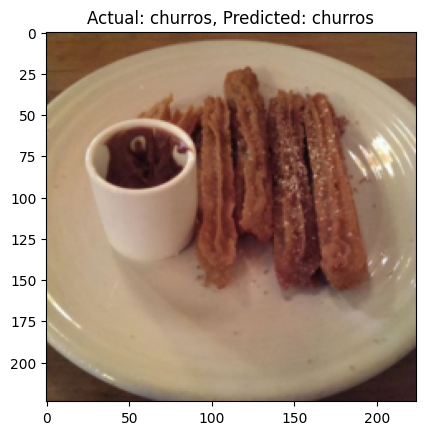

In [19]:
# prompt: write cod that make prediction on single image of dataset   with our trained model   and then print or plot the results  with lables actual name not the integers for it

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your trained student model and test dataset loaded
# ... (your existing code for model loading and dataset loading) ...

# Get a single image from the test dataset
image, label = test_set[200]

# Make a prediction
with torch.no_grad():
    output = student(image.unsqueeze(0))  # Add a batch dimension

# Get the predicted class
predicted_class = torch.argmax(output[0]).item()

# Assuming you have a mapping from class indices to actual class names
class_names = test_set.classes  # Replace with your actual class names mapping

# Print the results
print(f"Actual Class: {class_names[label]}")
print(f"Predicted Class: {class_names[predicted_class]}")

# Optionally, display the image and the prediction
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"Actual: {class_names[label]}, Predicted: {class_names[predicted_class]}")
plt.show()